<a href="https://colab.research.google.com/github/frank-lacriola/Data-Science-Lab/blob/main/Lab9_Regression_NY_AirBnB/Lab9_Regression_AirBnB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 !wget https://github.com/dbdmg/data-science-lab/raw/master/datasets/NYC_Airbnb.zip

--2021-12-22 23:38:03--  https://github.com/dbdmg/data-science-lab/raw/master/datasets/NYC_Airbnb.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dbdmg/data-science-lab/master/datasets/NYC_Airbnb.zip [following]
--2021-12-22 23:38:04--  https://raw.githubusercontent.com/dbdmg/data-science-lab/master/datasets/NYC_Airbnb.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2563162 (2.4M) [application/zip]
Saving to: ‘NYC_Airbnb.zip’

NYC_Airbnb.zip      100%[===================>]   2.44M  --.-KB/s    in 0.07s   

2021-12-22 23:38:04 (36.6 MB/s) - ‘NYC_Airbnb.zip’ saved [2563162/2563162]



In [2]:
!unzip "/content/NYC_Airbnb.zip"

Archive:  /content/NYC_Airbnb.zip
   creating: NYC_Airbnb/
  inflating: NYC_Airbnb/development.csv  
  inflating: __MACOSX/NYC_Airbnb/._development.csv  
  inflating: NYC_Airbnb/sample_submission.csv  
  inflating: __MACOSX/NYC_Airbnb/._sample_submission.csv  
  inflating: NYC_Airbnb/evaluation.csv  
  inflating: __MACOSX/NYC_Airbnb/._evaluation.csv  


In [3]:
from sklearn.datasets import make_regression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer
from sklearn.compose import make_column_transformer
import pandas as pd
import seaborn as sns
from prettytable import PrettyTable
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [4]:
df = pd.read_csv("/content/NYC_Airbnb/development.csv", index_col=0)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39116 entries, 12783632 to 15310580
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            39103 non-null  object 
 1   host_id                         39116 non-null  int64  
 2   host_name                       39097 non-null  object 
 3   neighbourhood_group             39116 non-null  object 
 4   neighbourhood                   39116 non-null  object 
 5   latitude                        39116 non-null  float64
 6   longitude                       39116 non-null  float64
 7   room_type                       39116 non-null  object 
 8   price                           39116 non-null  int64  
 9   minimum_nights                  39116 non-null  int64  
 10  number_of_reviews               39116 non-null  int64  
 11  last_review                     31075 non-null  object 
 12  reviews_per_month     

In [6]:
df.head()

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,,,,,,,,
12783632,NYC Mini Hotel,57230304,Imanuelly,Queens,Elmhurst,40.74037,-73.88610,Private room,75,1,2,2019-05-26,0.92,3,351
3463385,Gorgeous room in Manhattan,10698270,Evgenia,Manhattan,Upper East Side,40.76717,-73.95532,Private room,95,1,202,2019-05-27,3.31,2,263
17572926,Great 1 Bedroom on Upper East,36578169,James,Manhattan,Upper East Side,40.77984,-73.94725,Entire home/apt,130,2,0,NaN,NaN,1,0
33913644,"Modern and bright 2Bed 2Bath Bushwick, Brooklyn",50981314,Ofier,Brooklyn,Bushwick,40.70205,-73.91338,Entire home/apt,150,2,4,2019-07-07,1.64,1,89
9405895,Stylish and zen Brooklyn retreat,48775347,Mathieu,Brooklyn,Fort Greene,40.68914,-73.97853,Entire home/apt,325,3,16,2019-04-20,0.42,1,103


In [7]:
df.describe()

,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,3.911600e+04,39116.000000,39116.000000,39116.000000,39116.000000,39116.000000,31075.000000,39116.000000,39116.000000
mean,6.753109e+07,40.729037,-73.952308,153.406995,7.053073,23.261658,1.376466,7.204827,112.957613
std,7.863542e+07,0.054373,0.045880,242.218222,20.494289,44.601529,1.683171,33.109702,131.576326
min,2.438000e+03,40.507080,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,7.824647e+06,40.690260,-73.983160,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,3.059726e+07,40.723240,-73.955700,108.000000,3.000000,5.000000,0.720000,1.000000,46.000000
75%,1.074344e+08,40.763130,-73.936530,178.000000,5.000000,23.000000,2.020000,2.000000,226.000000
max,2.743213e+08,40.913060,-73.716900,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


We look for any irregularity in attribute distribution:

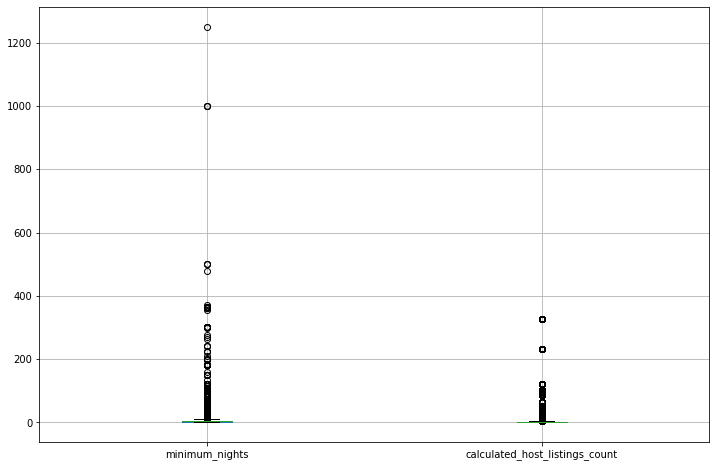

In [8]:
df.boxplot(column=['minimum_nights', 'calculated_host_listings_count'], figsize=(12, 8))

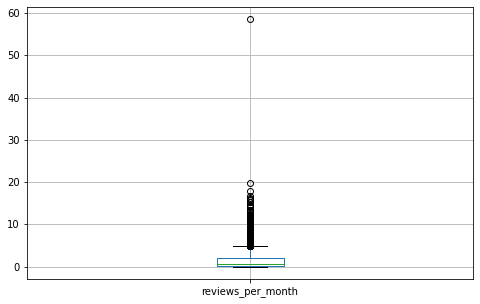

In [9]:
df.boxplot(column='reviews_per_month', figsize=(8, 5))

In [10]:
df.isna().any()

name                               True
host_id                           False
host_name                          True
neighbourhood_group               False
neighbourhood                     False
latitude                          False
longitude                         False
room_type                         False
price                             False
minimum_nights                    False
number_of_reviews                 False
last_review                        True
reviews_per_month                  True
calculated_host_listings_count    False
availability_365                  False
dtype: bool

We find out that both last_review and reviews_per_month can be NaN. A reasonable
explanation could be that, for those listings that have received no reviews

Handling missing values:

In [11]:
df['reviews_per_month'].fillna(value=0, inplace=True)

We can decide to represent neighbourhood_group, neighbourhood and room type with integers:

In [12]:
df['neighbourhood'].unique().shape

(221,)

In [13]:
df['neighbourhood_group'].unique()

array(['Queens', 'Manhattan', 'Brooklyn', 'Bronx', 'Staten Island'],
      dtype=object)

In [14]:
df['room_type'].unique()

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

Let's make other kind of preprocessing:

In [15]:
# preprocessing date for regression
import datetime as dt

df['last_review'] = pd.to_datetime(df['last_review']).map(dt.datetime.toordinal)

# Let's perform Regression Pipeline:

In [16]:
models = [
  LinearRegression(),
  Ridge(random_state=42),
  MLPRegressor(hidden_layer_sizes=(10,), random_state=42, max_iter=10000),
  MLPRegressor(hidden_layer_sizes=(10,10), activation='tanh', solver='lbfgs',
    alpha=0.000, batch_size='auto', learning_rate='constant',
    learning_rate_init=0.01, power_t=0.5, max_iter=10000,
    shuffle=True, random_state=42, tol=0.0001, verbose=True, warm_start=False,
    momentum=0.0, nesterovs_momentum=False, early_stopping=False, 
    validation_fraction=0.0, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
  SVR(gamma='scale'),
  RandomForestRegressor(n_estimators=300), 
  make_pipeline(
  make_column_transformer(
    (FunctionTransformer(np.sin), [0]),
    (PolynomialFeatures(5), [0])
    ),

  LinearRegression()),
  make_pipeline(
  make_column_transformer(
    (FunctionTransformer(np.sin), [0]),
    (PolynomialFeatures(5), [0])
    ),
  Ridge(alpha=1)
  )
]



names = [
  'linreg',
  'ridge',
  'mlp_standard',
  'mlp_tuned',
  'svr',
  'rf',
  f'sin+poly{5}+linreg',
  f'sin+poly{5}+ridge'
]

Let's do regression without categorical attributes:

In [17]:
df.columns

Index(['name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood',
       'latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')

In [18]:
df_drop = df.drop(columns=["host_id", "name", "host_name", "last_review"])

In [19]:
# This perform one-hot encoding
df_drop = pd.get_dummies(df_drop, columns=["neighbourhood_group","neighbourhood", "room_type"], prefix=["group", "zone", "room"])

In [21]:
t = PrettyTable()
t.field_names = ['model', 'MSE', 'R2']
model =  RandomForestRegressor(100, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(df_drop.drop(columns='price'), df_drop['price'],
  train_size=.7,
  random_state=42,
  shuffle=True)
model.fit(X_train, y_train)
y_hat = model.predict(X_test)
mse = mean_squared_error(y_test, y_hat)
r2 = r2_score(y_test, y_hat)
t.add_row(['RF', mse, r2])
print(t)

+-------+--------------------+---------------------+
| model |        MSE         |          R2         |
+-------+--------------------+---------------------+
|   RF  | 45507.980829237335 | 0.06007130410277861 |
+-------+--------------------+---------------------+


The random foret regressor we have trained can help us determine how useful each feature is for
the model

In [22]:
sorted(zip(df_drop.drop(columns=['price']).columns, model.feature_importances_), key=lambda x: x[1], \
        reverse=True)

[('longitude', 0.19531958162539256),
 ('latitude', 0.19260976793612938),
 ('availability_365', 0.09931319100601685),
 ('minimum_nights', 0.0865975498991029),
 ('reviews_per_month', 0.06671127288266526),
 ('room_Entire home/apt', 0.059172360232891186),
 ('calculated_host_listings_count', 0.05576273049387783),
 ('number_of_reviews', 0.04714926017170854),
 ('zone_Astoria', 0.04139341216319777),
 ('zone_Battery Park City', 0.025550585848364425),
 ('zone_Upper West Side', 0.014064247071532402),
 ('zone_Clinton Hill', 0.013171040528292299),
 ('zone_Bedford-Stuyvesant', 0.01000645683367144),
 ('zone_Lower East Side', 0.00804173963796789),
 ('zone_Randall Manor', 0.006175028369909121),
 ('zone_Tribeca', 0.004297777118487053),
 ('zone_Chelsea', 0.004089506570170703),
 ('zone_Williamsburg', 0.0038499654893919444),
 ('zone_Midtown', 0.00379064951298688),
 ('group_Queens', 0.003696010843852792),
 ('zone_Theater District', 0.0033626161781590744),
 ('zone_West Village', 0.003254487357686249),
 ('zon

As we can notice, the model doesn't make use of neighborhood group and zone, we can try to discard them.

In [24]:
df_1h = pd.get_dummies(df, columns=['room_type'])
# discard "neighbourhood" and "neighbourhood_group"
df_dropped = df_1h.drop(columns=["neighbourhood_group","neighbourhood","host_id", "name",\
                                 "host_name", "last_review"])
feature_names = df_dropped.drop(columns=["price"]).columns
X = df_dropped.drop(columns=["price"]).values
y = df_dropped["price"].values

t = PrettyTable()
t.field_names = ['model', 'MSE', 'R2']
model =  RandomForestRegressor(100, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y,
  random_state=42,
  shuffle=True)
model.fit(X_train, y_train)
y_hat = model.predict(X_test)
mse = mean_squared_error(y_test, y_hat)
r2 = r2_score(y_test, y_hat)
t.add_row(["RF", mse, r2])
print(t)

+-------+-------------------+---------------------+
| model |        MSE        |          R2         |
+-------+-------------------+---------------------+
|   RF  | 49037.84247009919 | 0.10485905409912633 |
+-------+-------------------+---------------------+


In [25]:
sorted(zip(feature_names, model.feature_importances_), key=lambda x: x[1], \
       reverse=True)

[('longitude', 0.3106356538341069),
 ('latitude', 0.2432212751382898),
 ('availability_365', 0.10206173081645416),
 ('minimum_nights', 0.09453420146707416),
 ('reviews_per_month', 0.07067698724606092),
 ('room_type_Entire home/apt', 0.06307473812272034),
 ('calculated_host_listings_count', 0.06097854808980696),
 ('number_of_reviews', 0.053690275059188476),
 ('room_type_Shared room', 0.0007054953430413454),
 ('room_type_Private room', 0.0004210948832570403)]

Now, we'll try to add one of the dropped columns one at time and then together.

In [26]:
for include_features in [["id"], ["host_id"], ["id", "host_id"]]:
  df_1h = pd.get_dummies(df, columns=['room_type'])
  # Extract the "id" information
  if "id" in include_features:
    df_1h["id"] = df_1h.index
  
  df_dropped = df_1h.drop(columns=["neighbourhood_group","neighbourhood",\
                                     "name", "host_name", "last_review"])
  
  # if "host_id" should not be kept, it is discarded
  if "host_id" not in include_features:
    df_dropped = df_dropped.drop(columns=["host_id"])
  feature_names = df_dropped.drop(columns=["price"]).columns
  X = df_dropped.drop(columns=["price"]).values
  y = df_dropped["price"].values

  X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, random_state=42)
  reg = RandomForestRegressor(100, random_state=42)
  reg.fit(X_train, y_train)
  print(include_features, r2_score(y_valid, reg.predict(X_valid)))


['id'] 0.11644446892306404
['host_id'] 0.11778902062981622
['id', 'host_id'] 0.13278619065870456


We'll include both of them.
Now let's try to encode 'name', the title of the item:

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words="english", binary=True, use_idf=False,\
                             norm=False)
# word presence matrix (i-th row, j-th col => 1 if j-th word is contained in 
# i-th title)
wpm = vectorizer.fit_transform(df_1h["name"].fillna(""))
# We take the N most popular words and add a boolean feature for each of them.
N = 150
freq = sorted(zip(vectorizer.get_feature_names(), wpm.sum(axis=0).tolist()[0]),\
              key=lambda x: x[1], reverse=True)[:N]
freq

In [30]:
print(wpm.shape)

(39116, 6890)


In [32]:
 import numpy as np
# mask to be used to filter columns in wpm (only keeps the ones for the 100 most
# frequent words)
words = [ word for word, _ in freq ]
mask = [ w in words for w in vectorizer.get_feature_names() ]
words_ = [ w for w in vectorizer.get_feature_names() if w in words ]
words_df = pd.DataFrame(data=wpm[:, np.array(mask)].toarray(), \
                        columns=[f"word_{word}" for word in words_], index=df_1h.index)
# Only encode "room_type"
df_1h = pd.get_dummies(df, columns=['room_type'])
df_1h = df_1h.join(pd.DataFrame(data=wpm[:, np.array(mask)].toarray(),\
                                columns=[f"word_{word}" for word in words_], index=df_1h.index))
# discard "neighbourhood" and "neighbourhood_group"
df_dropped = df_1h.drop(columns=["neighbourhood_group","neighbourhood", "name",\
                                 "host_name", "last_review"])

feature_names = df_dropped.drop(columns=["price"]).columns
X = df_dropped.drop(columns=["price"]).values
y = df_dropped["price"].values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True,\
                                                      random_state=42)
reg = RandomForestRegressor(100, random_state=42)
reg.fit(X_train, y_train)
r2_score(y_valid, reg.predict(X_valid))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


0.15120205841835732

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
"n_estimators": [100, 250, 500],
"criterion": ["mse", "mae"],
"max_features": ["auto", "sqrt", "log2"],
"random_state": [42], # always use the samet random seed
"n_jobs": [-1], # for parallelization
}
gs = GridSearchCV(RandomForestRegressor(), param_grid, scoring="r2", n_jobs=-1,\
                  cv=5)
gs.fit(X_train_valid, y_train_valid)
gs.best_score_

Let's try to normalize using Standard Scaler:

In [ ]:
interesting_models = [
  Ridge(random_state=42),
  RandomForestRegressor(n_estimators=300), 
]

interesting_names = [
  'ridge',
  'rf',
]

In [ ]:
from sklearn.preprocessing import StandardScaler

# create an abs_scaler object
scaler = StandardScaler()

# calculate the maximum absolute value for scaling the data using the fit method
scaler.fit(df_drop_cat_na.iloc[:, :9])

# transform the data using the parameters calculated by the fit method (the maximum absolute values)
scaled_data = scaler.transform(df_drop_cat_na.iloc[:, :9])

# store the results in a data frame
df_drop_cat_na.iloc[:, :9] = scaled_data

# visualize the data frame
df_drop_cat_na

In [ ]:
df_drop_cat_na.columns

In [ ]:
t = PrettyTable()
t.field_names = ['model', 'MSE', 'R2']
for model, name in zip(interesting_models, interesting_names):
  X_train, X_test, y_train, y_test = train_test_split(df_drop_cat_na.drop(columns='price'), df_drop_cat_na['price'],
    train_size=.7,
    random_state=42,
    shuffle=True)
  model.fit(X_train, y_train)
  y_hat = model.predict(X_test)
  mse = mean_squared_error(y_test, y_hat)
  r2 = r2_score(y_test, y_hat)
  t.add_row([name, mse, r2])
print(t)

In [ ]:
df_drop_cat_na.info()

Let's try a Grid Search:

In [ ]:
lasso_params = {'alpha':[0.02, 0.024, 0.025, 0.026, 0.03]}
ridge_params = {'alpha':[200, 230, 250,265, 270, 275, 290, 300, 500]}

models2 = {'OLS': LinearRegression(),
           'Ridge': GridSearchCV(Ridge(random_state=42), 
                               param_grid=ridge_params).fit(df_drop_cat_na.drop(columns='price'), df_drop_cat_na['price']).best_estimator_}

In [ ]:
models2['Ridge']

In [ ]:
t = PrettyTable()
t.field_names = ['model', 'MSE', 'R2']
for model, name in zip(models2.values(), names):
  X_train, X_test, y_train, y_test = train_test_split(df_drop_cat_na.drop(columns='price'), df_drop_cat_na['price'],
    train_size=.7,
    random_state=42,
    shuffle=True)
  X_train, X_test, _ = select_features(X_train, y_train, X_test)
  model.fit(X_train, y_train)
  y_hat = model.predict(X_test)
  mse = mean_squared_error(y_test, y_hat)
  r2 = r2_score(y_test, y_hat)
  t.add_row([name, mse, r2])
print(t)

In [ ]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from matplotlib import pyplot


# feature selection
def select_features(X_train, y_train, X_test):
	# configure to select all features
	fs = SelectKBest(score_func=f_regression, k=13)
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

In [ ]:
X_train.shape